In [1]:
from IPython.display import HTML
HTML('''
<script>
code_show=false;
function code_toggle(){
    if(code_show){$('.prompt, .input, .output_stderr, .output_error').hide();}
    else{$('.input, .prompt, .output_stderr, .output_error').show();}
    code_show=!code_show;
}
function initialize(){
    var output=$('.output_subarea.output_text.output_stream.output_stdout');
    $.merge(output,$('.output_subarea.output_text.output_result'));
    for(var i=0;i<output.length;i++)for(var j=0;j<output[i].children.length;j++)
        output[i].children[j].style.fontFamily='Palatino';
    code_toggle();
}
$(document).ready(initialize);
</script>
Click <a href="javascript:code_toggle()">here</a> to show/hide codes in this notebook.
''')

# Error Propagation of Radon transform
Let $I \in \mathbb{N}^{r \times v}$ be a sinogram and the function $f: \mathbb{N}^{r \times v} \rightarrow \mathbb{N}^{n \times n}$ is the inverse radon transorm. Further be $F_x$ the Jacobian of $f$:
\begin{align}
    F_x &= \left[ \nabla f^T \right]^T &= \left[\begin{array}{c}
        f_1 \\
        \vdots \\
        f_{nn}
    \end{array}\right] \left[\begin{array}{ccc} \frac{\partial}{\partial I_1} & \dots & \frac{\partial}{\partial I_{rn}} \end{array}\right] &= \left[\begin{array}{ccc}
        \frac{\partial f_1}{\partial I_1} & \dots & \frac{\partial f_1}{\partial I_{rv}} \\
        \vdots & \ddots & \vdots \\
        \frac{\partial f_{nn}}{\partial I_1} & \dots & \frac{\partial f_{nn}}{\partial I_{rv}}
    \end{array}\right]
\end{align}

We now assume that $I$~$\mathcal{N}(\mu, \Sigma)$ is a realization of a multivariate normal distribution. The covariance matrix $\Sigma$ can be modelled in a way, that the correlation factor $\rho(i, j)$ is higher for columns $j$ and stays constant for rows $i$. We use exponential decay for the columns:
$$
    \rho(i) = exp( - \gamma i)
$$

The propagation of the uncertanty $\Sigma$ can be computed as followed:
$$
    \Sigma_f = F_x \Sigma F_x^T
$$

In [2]:
import os
from os import path
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as la
from scipy import special
import tensorflow as tf
import tensorflow_probability as tfp
from skimage import transform
from scipy.interpolate import interp1d
from error_propagation_radon_transform import utils
import pydicom

import importlib
importlib.reload(utils)

from ipywidgets import interact, widgets, interactive_output
from IPython.display import display

# Exponential Decay
$$
    \rho(i) = \exp(-\gamma i)
$$

In [3]:
def exponential(value, gamma):
    return np.exp( - gamma * value)

@interact(width=(2,50))
def interactive_exponential(width=15):
    x = np.arange(0,width)
    y = exponential(x, 1/np.log(width))
    plt.bar(x, y)
    plt.show()

interactive(children=(IntSlider(value=15, description='width', max=50, min=2), Output()), _dom_classes=('widge…

# Covariance Matrix

In [4]:
@interact(width=(1, 32))
def interact_cov(width=10):
    var = np.ones((16,16))
    covar = utils.build_covariance_matrix(var, function=exponential, width=width)

    impulse = np.zeros_like(var)
    impulse[var.shape[0]//2, var.shape[1]//2] = 1.0

    response = covar @ impulse.flatten()

    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.imshow(covar)
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(response.reshape(var.shape))
    plt.colorbar()
    plt.show()
    
    plt.plot(response.reshape(var.shape)[var.shape[0]//2:, var.shape[1]//2])
    plt.show()

interactive(children=(IntSlider(value=10, description='width', max=32, min=1), Output()), _dom_classes=('widge…

In [5]:
ds = pydicom.read_file('../Data/Train_Sets/CT/1/DICOM_anon/i0024,0000b.dcm')
ConstPixelDims = (int(ds.Rows), int(ds.Columns))
ConstPixelSpacing = (float(ds.PixelSpacing[0]), float(ds.PixelSpacing[1]), float(ds.SliceThickness))

ct_scan = np.zeros(ConstPixelDims, dtype=ds.pixel_array.dtype)
ct_scan[:,:] = ds.pixel_array

ct_scan = ct_scan[::8,::8]
img_shape = ct_scan.shape[0]

ct_scan = ct_scan / ct_scan.max() * 255

print(ct_scan.shape)

(64, 64)


/home/vik/Programme/anaconda3/envs/ai-cpu/lib/python3.8/site-packages/skimage/transform/radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


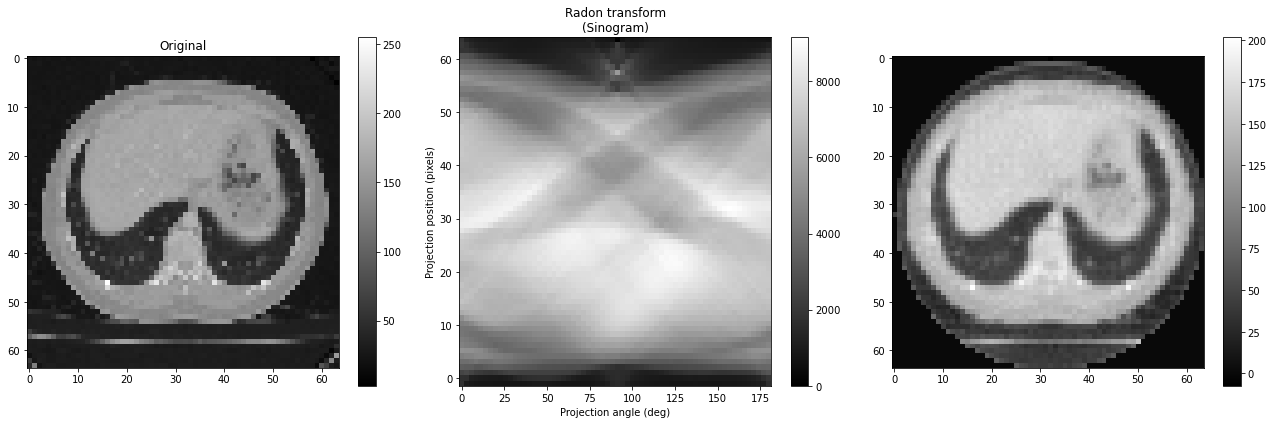

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.set_title('Original')
kid = ax1.imshow(ct_scan, cmap='gray')

plt.colorbar(kid, ax=ax1)

theta = np.linspace(0., 180., max(ct_scan.shape), endpoint=False)
sinogram = transform.radon(ct_scan, theta=theta)
dx, dy = 0.5 * 180.0 / max(ct_scan.shape), 0.5 / sinogram.shape[0]
ax2.set_title('Radon transform\n(Sinogram)')
ax2.set_xlabel('Projection angle (deg)')
ax2.set_ylabel('Projection position (pixels)')
sin = ax2.imshow(sinogram, cmap='gray', extent=(-dx, 180 + dx, -dx, sinogram.shape[0] + dy), aspect='auto')

plt.colorbar(sin, ax=ax2)

reconstructed = transform.iradon(sinogram, theta=theta, filter_name='ramp')
re = ax3.imshow(reconstructed, cmap='gray')
plt.colorbar(re, ax=ax3)

fig.tight_layout()
plt.show()

In [7]:
jacobian, kidney_reconstructed = utils.compute_gradient(sinogram, theta, ct_scan.shape, 'ramp', None)
    
input_range = 2464
output_range = tf.reduce_max(kidney_reconstructed) - tf.reduce_min(kidney_reconstructed)
    
var = np.ones_like(sinogram) * input_range * 5e-2
Sigma_in = utils.build_covariance_matrix(var, function=exponential, width=5)

n = np.prod(ct_scan.shape)
jacobian_reshaped = tf.math.real(tf.reshape(jacobian, (n, n)))

Sigma = jacobian_reshaped @ Sigma_in @ tf.transpose(jacobian_reshaped)

In [8]:
print(2464 * 10e-2)

246.4


## Save the Jacobian/STD

In [8]:
if not path.exists('../Data/inverse_Radon_Transform'):
    os.mkdir('../Data/inverse_Radon_Transform')

np.save('../Data/inverse_Radon_Transform/sigma_64x64_expdecay246.4x10.npy', Sigma)

standard_deviation = tf.math.sqrt(tf.reshape(tf.linalg.tensor_diag_part(Sigma), kidney_reconstructed.shape))

np.save('../Data/inverse_Radon_Transform/std_64x64_expdecay246.4x10.npy', standard_deviation)

# Isocontour Density
$$
    g_\theta (x) = \frac{1}{\sigma(x)\sqrt{2\pi}} exp \left( - \frac{1}{2} \left( \frac{\theta - \mu(x)}{\sigma(x)} \right)^2 \right)
$$

The value of the function is related to the numerical condition of isocontour extraction. In other words, how sensitive is the extraction of the isocontour to small pertubations $d t$ based on the normal distribution.

In [9]:
def g(contour, mean, variance):
    inner = - 0.5 * ( (contour - mean) / variance)**2
    denumerator = variance * np.sqrt(2 * np.pi)
    return np.exp(inner)/denumerator

In [10]:
def plot_transform(theta):
    variance = tf.math.sqrt(tf.reshape(tf.linalg.tensor_diag_part(Sigma), kidney_reconstructed.shape))
    
    icd = g(theta, kidney_reconstructed, tf.math.real(variance))
    
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.title('reconstructed')
    plt.imshow(kidney_reconstructed, cmap='gray')
    plt.colorbar()
    plt.contour(kidney_reconstructed, [theta], colors='red')
    
    plt.subplot(1,2,2)
    plt.title('Isocontour Density')
    plt.imshow(icd)
    plt.colorbar()
    plt.contour(kidney_reconstructed, [theta], colors='red')
    
    plt.show()
    
max_theta = tf.reduce_max(kidney_reconstructed)
theta_slider = widgets.FloatSlider(155.0, min=0, max=max_theta, step=0.001, description=r'$\theta$', layout=widgets.Layout(left='-60px', width='390px'))

transform_ui = interactive_output(plot_transform, {
    'theta': theta_slider,
})

layout = widgets.VBox([
    theta_slider,
    transform_ui
])

display(widgets.VBox([
    layout
]))

# Level-Crossing Probability Field
$$
    P_\theta (x) = \frac{1}{2} \left( 1 - Erf \left( \frac{\mu(x) - \theta}{\sqrt{2} \sigma(x)} \right) \right)
$$

The value of the function can be interpreted as the probability of two independend realizations $y_a$ and $y_b$ of a random variable to be greater or equal to $\theta$, while the other is smaller or equal to $\theta$. In other words, how likely two independend realizations fullfill the fact that one is greater (or equal) and the other at the same time smaller (or equal) to $\theta$.

In [11]:
def lcp(contour, mean, variance):
    inner = (mean - contour) / (np.sqrt(2)*variance)
    return 0.5 * ( 1 - special.erf(inner)**2 )

In [12]:
def plot_transform(theta):
    variance = tf.math.sqrt(tf.reshape(tf.linalg.tensor_diag_part(Sigma), kidney_reconstructed.shape))
    
    cross_prob = lcp(theta, kidney_reconstructed, tf.abs(variance))
    
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.title('reconstructed')
    plt.imshow(kidney_reconstructed, cmap='gray')
    plt.colorbar()
    plt.contour(kidney_reconstructed, [theta], colors='red')
    
    plt.subplot(1,2,2)
    plt.title('Level-Crossing Probability Field')
    plt.imshow(cross_prob)
    plt.colorbar()
    plt.contour(kidney_reconstructed, [theta], colors='red')
    
    plt.show()
    
max_theta = tf.reduce_max(kidney_reconstructed)
theta_slider = widgets.FloatSlider(155.0, min=0, max=max_theta, step=0.001, description=r'$\theta$', layout=widgets.Layout(left='-60px', width='390px'))

transform_ui = interactive_output(plot_transform, {
    'theta': theta_slider,
})

layout = widgets.VBox([
    theta_slider,
    transform_ui
])

display(widgets.VBox([
    layout
]))